## Bayes

$p(\phi|d,m)=\frac{p(d|\phi,m)p(\phi,m)}{p(d|m)}$

donde

$p(d|\phi,m) = \mathcal{L}$: Likelihood

$p(\phi,m)$: priors o probabilidad anterior

$p(d|m)$: evidencia

$\mathcal{L} = \prod_{i=1}^{N} \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(y\, -\, y_{model})^2}{2\sigma^2}}$

$\mathrm{log}(\mathcal{L}) = A - \sum_{i=1}^{N} \frac{(y\, -\, y_{model})^2}{2\sigma^2}$

$\mathrm{log}(p(\phi|d,m)) = \mathrm{log}(\mathcal{L})\, +\, \mathrm{log}(p(\phi,m))\, -\, \mathrm{log}(p(d|m))$


## Metropolis Hasting Monte Carlo

* Tomar un estado inicial $x_{0}$
* Establecer $t=0$
* Iterar cuantas veces queramos
    * Generar un estado candidato x' siguiendo $g(x'|x_{t})$
    * Calcular la probabilidad de aceptación $A(x',x_{t})=\min \left(1,{\frac {P(x')}{P(x_{t})}}{\frac {g(x_{t}|x')}{g(x'|x_{t})}}\right)$
    * Aceptar o rechazar:
        * Generar un número aleatorio uniforme $u\in [0,1]$
        * Si $u\leq A(x',x_{t})$, se acepta el nuevo estado y se toma $x_{t+1}=x'$
        * Si $u>A(x',x_{t})$, se rechaza el nuevo estado y se toma el viejo estado $x_{t+1}=x_{t}$
    * Incrementar $t=t+1$

In [59]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.mlab import griddata

In [94]:
a = 7.3
b = -47.0
n = 100
sigma = 5.
np.random.seed(2317)

Text(0,0.5,'Y')

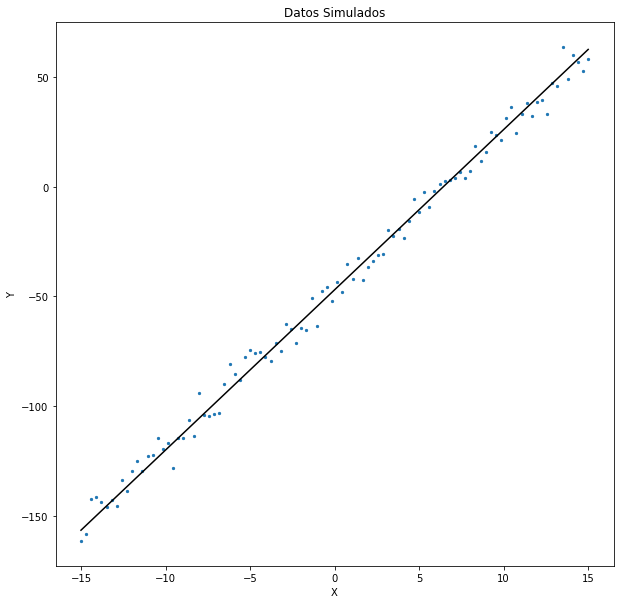

In [95]:
x_data = np.linspace(-15,15,n)
y_data = a*x_data + b

error = np.random.normal(scale=sigma,size=n)
y_data = y_data + error

plt.figure(figsize=(10,10))
plt.scatter(x_data,y_data,s=5.0) 
plt.plot(x_data, x_data*a+b, 'k')

plt.title('Datos Simulados') 
plt.xlabel('X') 
plt.ylabel('Y')

In [96]:
salto1 = 0.5
salto2 = 0.5 

def plot_MCMC(ax,x,y,nbins=30): 
    L, xbins, ybins = np.histogram2d(x,y,nbins)
    shape = L.shape 
    L = L.ravel()
    i_sort = np.argsort(L)[::-1] 
    i_unsort = np.argsort(i_sort) 
    L_cumsum = L[i_sort].cumsum() 
    L_cumsum /= L_cumsum[-1] 
    xbins = 0.5 * (xbins[1:] + xbins[:-1]) 
    ybins = 0.5 * (ybins[1:] + ybins[:-1]) 
    L = L_cumsum[i_unsort].reshape(shape)
    ax.contour(xbins, ybins, L.T, levels=[0.683, 0.955])
    
def q(x1,y1):
    x2 = x1 + np.random.uniform(low=-1.,high=1.)*salto1 
    y2 = y1 + np.random.uniform(low=-1.,high=1.)*salto2 
    return(x2,y2)

def Likelihood(y_model): 
    global y_data 
    L = -((y_data - y_model)**2)/(2.0*(sigma**2)) 
    return(np.sum(L))

def prior_pen(a): 
    if (0.0 < a < 10.0): 
        P_pend = 0.
    else : 
        P_pend = -np.inf 
    return P_pend

def prior_ord(b):
    if (-54 < b < -38): 
        P_ord = 0.
    else: 
        P_ord = -np.inf 
    return P_ord

def Priors(a,b):
    return(prior_pen(a)*prior_ord(b))

def posterior(y,a,b): 
    p = Likelihood(y) + Priors(a,b) 
    return p

In [97]:
def MH(a_est,b_est,m):
    
    global x_data,y_data
    
    
    k = 0
    r  = np.zeros(m)
    a  = np.zeros(m)
    b  = np.zeros(m)
    #m_ = np.arange(0,m) 
    #Like = np.zeros(m) 
    
    y = a_est*x_data + b_est 
        
    posteriori_1 = posterior(y,a_est,b_est)
    
    a[0] = a_est 
    b[0] = b_est
    r[0] = posteriori_1
    
    for j in range(1,m):
        
        #Like[j] = Likelihood(y)
        
        (a_new, b_new) = q(a_est,b_est)
        
        y2 = a_new*x_data + b_new
        
        posteriori_2 = posterior(y2,a_new,b_new)
        
        alpha = posteriori_2 - posteriori_1
        u = np.log(np.random.uniform()) 
        if u < alpha:
            #Aceptamos el salto
            a_est = a_new 
            b_est = b_new
            posteriori_1 = posteriori_2
            k = k + 1
            
            a[k] = a_new
            b[k] = b_new
            r[k] = posteriori_2
        
        
            
    return(a[:k+1],b[:k+1],r[:k+1],k)

In [98]:
#Condiciones iniciales
a_est =   8.5
b_est = -40.0
m = 100000

('tasa de aceptacion', 0.16476, 'Pto. con mayor prob.', array([ 7.17327842]), array([-46.82316668]))


Text(0,0.5,'$b_{est}$')

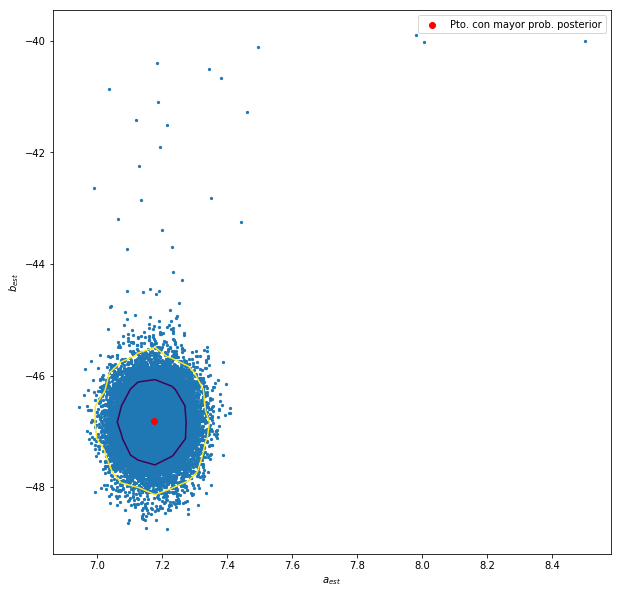

In [99]:
a, b, r, k = MH(a_est,b_est,m)

f = plt.figure(figsize=(10,10)) 
ax = f.add_subplot(111)

ax.scatter(a,b,s=5)

mask = (r == max(r))
Max_a = a[mask] 
Max_b = b[mask]

print("tasa de aceptacion",float(k)/float(m),"Pto. con mayor prob.",Max_a,Max_b)

ax.scatter(Max_a,Max_b,color="red",label="Pto. con mayor prob. posterior") 

plot_MCMC(ax,a,b)

ax.legend() 
ax.set_xlabel('$a_{est}$') 
ax.set_ylabel('$b_{est}$')